In [1]:
from pandas import DataFrame, read_csv, to_numeric
from pandas_ml import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from bigml.api import BigML
import kaggle

%matplotlib inline

In [4]:
compression = True  #Do we compress the csv files?

version='v1.3'

big_ml_project = 'project/5d94a428eba31d460c00023f'

In [5]:
if compression:
    compress='.bz2'
else:
    compress=''

filenames = ["",""]
  
filename_fulltrain = 'gmsc-fulltrain-' + version + '.csv'+ compress
filename_train = 'gmsc-train80-' + version + '.csv'+ compress
filename_valid = 'gmsc-valid20-' + version + '.csv'+ compress
filename_test = 'gmsc-test-' + version + '.csv'+ compress
filename_valid_prediction = 'gmsc-valid-pred-' + version + '.csv'
filename_test_prediction = 'gmsc-test-pred-' + version + '.csv'

filename_bigml_ids = 'bigml-' + version + '.csv'+ compress

## Big ML evaluation

In [5]:
api = BigML(project=big_ml_project)

bigml_ids = read_csv(filename_bigml_ids, squeeze=True, index_col=0)

model = api.get_ensemble(bigml_ids['model'])
valid_ds = api.get_dataset(bigml_ids['validation dataset'])

AttributeError: Cannot find BIGML_USERNAME in your environment

### Big ML batch prediction

In [ ]:
try:
    batch_prediction = api.get_batch_prediction(bigml_ids['validation prediction'])
except:
    do_prediction = True
else:
    ds_changed = batch_prediction['object']['dataset'] != bigml_ids['validation dataset']
    model_changed = batch_prediction['object']['ensemble'] != bigml_ids['model']
    do_prediction = ds_changed or model_changed

In [ ]:
if do_prediction:
    batch_prediction = api.create_batch_prediction(model, valid_ds, {
        "name": "my batch prediction" + version,
        "all_fields": True,
        "header": True,
        "confidence": True,
        "probabilities": True}                      )
    api.ok(batch_prediction)
    api.download_batch_prediction(batch_prediction,
                                filename=filename_valid_prediction)
    bigml_ids['validation prediction']=batch_prediction['resource']
    bigml_ids.to_csv(filename_bigml_ids, header=False)
print(bigml_ids['validation prediction'])

Open BigML predictions

In [6]:
prediction=read_csv(filename_valid_prediction, index_col='Id')

scikit learn auc

In [30]:
#%%timeit -n100
score = roc_auc_score(prediction['SeriousDlqin2yrs'].values,prediction['1 probability'].values)
print(score)

5.5 ms ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


scikit learn roc curve

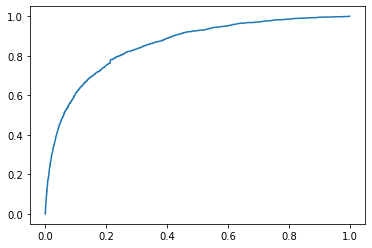

In [8]:
fpr, tpr, thresholds = roc_curve(prediction['SeriousDlqin2yrs'],prediction['1 probability'])
plt.plot(fpr, tpr)
plt.show()

### Big ML evaluation

In [9]:
try:
    evaluation = api.get_evaluation(bigml_ids['evaluation'])
except:
    do_prediction = True
else:
    ds_changed = batch_prediction['object']['dataset'] != bigml_ids['validation dataset']
    model_changed = batch_prediction['object']['ensemble'] != bigml_ids['model']
    do_prediction = ds_changed or model_changed

In [10]:
if do_prediction:
    evaluation = api.create_evaluation(model, valid_ds)
    api.ok(evaluation)
    bigml_ids['evaluation']=evaluation['resource']
    bigml_ids.to_csv(filename_bigml_ids, header=False)
    
#api.pprint(evaluation['object']['result'])
print('evaluation id:', evaluation['resource'])

NameError: name 'api' is not defined

Big ML auc and confusion matrix

In [ ]:
print('auc:', evaluation['object']['result']['model']['average_area_under_roc_curve'])
DataFrame(evaluation['object']['result']['model']['confusion_matrix'])

### Plot the cost as a function of the threshold using BigML evaluation

In [11]:
per_thres_conf_matrix = evaluation['object']['result']['model']['per_class_statistics'][1]['per_threshold_confusion_matrices']

NameError: name 'evaluation' is not defined

In [9]:
#TP, FP, TN ,FN
cost_matrix = DataFrame([0,-500,500,-2500])
per_thres_cost_BigML=[]
threshold_BigML=[]
for table in per_thres_conf_matrix:
    matrix = DataFrame(table[0])
    threshold_BigML.append(table[1])
    per_thres_cost_BigML.append((cost_matrix * matrix).sum())
plt.plot(threshold_BigML, per_thres_cost_BigML)
plt.show()

NameError: name 'per_thres_conf_matrix' is not defined

## Error analysis

In [10]:
is_positive = (prediction['SeriousDlqin2yrs'] == 1)
is_predicted_positive = (prediction['SeriousDlqin2yrs.1'] == 1)

nb_positive = len(prediction.loc[is_positive])
nb_negative = len(prediction.loc[~is_positive])

total = len(prediction)

is_true_positive = is_positive & is_predicted_positive
is_true_negative = ~is_positive & ~is_predicted_positive
is_false_positive = ~is_positive & is_predicted_positive
is_false_negative = is_positive & ~is_predicted_positive

prediction.loc[is_true_positive,'prediction_class']='TP'
prediction.loc[is_true_negative,'prediction_class']='TN'
prediction.loc[is_false_positive,'prediction_class']='FP'
prediction.loc[is_false_negative,'prediction_class']='FN'

### Take the 100 biggest errors

In [11]:
prediction['absolute_error']=(prediction['1 probability']-prediction['SeriousDlqin2yrs']).abs()
prediction_errors = prediction.sort_values(by='absolute_error', ascending=False).head(100)

### Confusion matrix

In [20]:
confusion_matrix = ConfusionMatrix(prediction['SeriousDlqin2yrs'],prediction['SeriousDlqin2yrs.1'])


d = {'P\u0302': [confusion_matrix.TP, confusion_matrix.FP, confusion_matrix.PPV],
     'N\u0302': [confusion_matrix.FN, confusion_matrix.TN, confusion_matrix.NPV],
     'Recall': [confusion_matrix.TPR, confusion_matrix.TNR, confusion_matrix.ACC]}
confusion_matrix_df = DataFrame(data=d,index=['P','N', 'Precision'])
confusion_matrix_df


,P̂,N̂,Recall
P,361.000000,1720.000000,0.173474
N,251.000000,27668.000000,0.991010
Precision,0.589869,0.941473,0.934300


In [12]:
TP = len(prediction.loc[is_true_positive])
TN = len(prediction.loc[is_true_negative])
FP = len(prediction.loc[is_false_positive])
FN = len(prediction.loc[is_false_negative])

TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
PPV=TP/(TP+FP)
NPV=TN/(TN+FN)
accuracy=(TP+TN)/(TP+TN+FP+FN)

d = {'P\u0302': [TP, FP, PPV], 'N\u0302': [FN, TN, NPV], 'Recall': [TPR, TNR, accuracy]}
confusion_matrix = DataFrame(data=d,index=['P','N', 'Precision'])
confusion_matrix

,P̂,N̂,Recall
P,361.000000,1720.000000,0.173474
N,251.000000,27668.000000,0.991010
Precision,0.589869,0.941473,0.934300


### Cost optimization

In [ ]:
def cost_threshold(threshold):
    prediction_threshold = prediction['1 probability'] > threshold

    is_P_pred = prediction_threshold
    is_N_pred = ~prediction_threshold

    is_P_real = (prediction['SeriousDlqin2yrs'] == 1)
    is_N_real = (prediction['SeriousDlqin2yrs'] == 0)

    TP = len(prediction.loc[is_P_pred & is_P_real])
    TN = len(prediction.loc[is_N_pred & is_N_real])
    FP = len(prediction.loc[is_P_pred & is_N_real])
    FN = len(prediction.loc[is_N_pred & is_P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

In [ ]:
table = [cost_threshold(n/1000) for n in range(0,1000)]
threshold = [n/1000 for n in range(0,1000)]
plt.axis([0, 1,min(table),1.2*max(table)])
plt.plot(threshold, table)
plt.show()

### Compute the maximum gain from a sample of threshold

In [ ]:
max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

### Compute the cost for all thresholds

In [ ]:
threshold_list = prediction['1 probability'].sort_values().values
threshold_intervals = []
for i in range(len(threshold_list)-1):
    midpoint=(threshold_list[i]+threshold_list[i+1])/2
    threshold_intervals.append(midpoint)
table = [cost_threshold(t) for t in threshold_intervals]

In [ ]:
max_val = max(table)
max_threshold = threshold_intervals[table.index(max_val)]
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

### faster cost computation

In [35]:
#%%timeit -n20
df_cost = prediction[['SeriousDlqin2yrs','1 probability']]
df_cost = df_cost.sort_values(by='1 probability',ascending=False)

df_cost['nb_TP'] = df_cost['SeriousDlqin2yrs'].cumsum()
df_cost['nb_FP'] = (1-df_cost['SeriousDlqin2yrs']).cumsum()
df_cost['nb_TN'] = nb_negative - df_cost['nb_FP']
df_cost['nb_FN'] = nb_positive - df_cost['nb_TP']

TP_cost = 0
FN_cost = -2500
FP_cost = -500
TN_cost = 500

df_cost['cost'] = df_cost['nb_TP']*TP_cost+df_cost['nb_TN']*TN_cost+df_cost['nb_FP']*FP_cost+df_cost['nb_FN']*FN_cost

Le gain maximum est 9828500.0 et il est obtenu avec un seuil de 0.24536999999999998


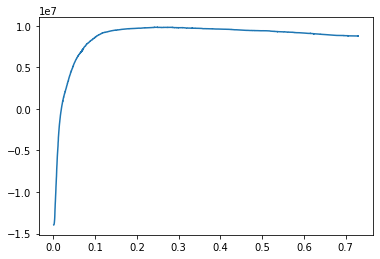

In [36]:
max_index = df_cost['cost'].idxmax()
max_gain = df_cost.loc[max_index]['cost']
max_threshold = df_cost.loc[max_index]['1 probability']
print(f'Le gain maximum est {max_gain} et il est obtenu avec un seuil de {max_threshold}')
plt.plot(df_cost['1 probability'],df_cost['cost'].values)
plt.show()

## AUC computation by hand
### The algorithm with a for loop
The ROC is a staircase curve. Each step down the threshold list, the curve move either by $1/P$ up or $1/N$ right.
* Each time it goes up (Real positive), you increment the $height$ by $1/P$
* Each time it goes right (Real negative), you add the rectangular area ($height \times 1/N$) to the auc

You can optimize by incrementing by 1 in each direction and dividing by $N \times P$ at the end 

In [25]:
is_positive = (prediction['SeriousDlqin2yrs'] == 1)
is_negative = (prediction['SeriousDlqin2yrs'] == 0)
positives = prediction[is_positive]
negatives = prediction[is_negative]

nb_positive=len(positives)
nb_negative=len(negatives)
#nb_positive=positives.shape[0]
#nb_negative=negatives.shape[0]


```
score=0
c=0
for p in positives['1 probability']:
    for n in negatives['1 probability']:
        if p > n:
            c+=1
auc=c/(nb_positive*nb_negative)
print(auc)
```

In [ ]:
#%%timeit -n20
#threshold_list = prediction.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values
result = prediction[['SeriousDlqin2yrs','1 probability']]
threshold_list = result.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values

auc = 0
P_cumul = 0
for i in range(len(threshold_list)):
    if threshold_list[i] == 1:
        P_cumul += 1
    else:
        auc += P_cumul
        
auc = auc/(nb_positive*nb_negative)

In [ ]:
print(f'AUC={auc}')

### Computing the auc with pandas and no for loops
4 time faster.

In [29]:
#%%timeit -n100
df_threshold=DataFrame(index=prediction['1 probability'])
df_threshold['positive'] = positive.values
df_threshold.sort_index(inplace=True, ascending=False)

df_threshold['positive_sum'] =  df_threshold['positive'].cumsum()
auc=df_threshold.loc[~df_threshold['positive']]['positive_sum'].sum()/(nb_positive*nb_negative)

4.5 ms ± 78.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
print(f'AUC={auc}')

### Drawing the ROC by hand

In [ ]:
threshold_list = prediction.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values

tpr = []
fpr = []

positive_sum = 0
negative_sum = 0
for i in range(len(threshold_list)):
    if threshold_list[i] == 1:
        positive_sum += 1
    else:
        negative_sum += 1
    tpr.append(positive_sum/nb_positive)
    fpr.append(negative_sum/nb_negative)


In [ ]:
plt.plot(fpr,tpr)
plt.show()